In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import igraph as ig
import warnings
import random
import networkit as nk
warnings.filterwarnings("ignore")

In [90]:
# 3.1

In [22]:
small = pd.read_csv("twitter-small.tsv", header = None, delimiter='\t', parse_dates=[0])

In [23]:
small.rename(columns = {0:"Time", 1:"user", 2:"tweet"}, inplace = True)

In [27]:
small.duplicated().sum()

879

In [28]:
small.drop_duplicates(inplace = True)

In [36]:
import re
def get_mentioned(tweet):
    mention = re.findall(r'@(\w+)', tweet)
    return list(set(mention))

small["mention"] = small["tweet"].apply(get_mentioned)

In [38]:
small_mention = small.groupby('user')['mention'].agg(lambda s:sum(s, [])).reset_index()

In [53]:
small_mention['mention'] = small_mention.apply(lambda x: [mention for mention in x['mention'] if mention != x['user']], axis=1)

In [56]:
small_mention = small_mention[small_mention["mention"].apply(len) > 0]

In [66]:
from collections import Counter
small_mention["adj"] = small_mention["mention"].apply(lambda s: dict(Counter(s)))

In [78]:
small_mention[["user", "adj"]].to_csv("adj.csv", header = False, index = False)

In [88]:
def to_adj(x):
    user = x['user']
    mention_dict = x['adj']
    mentions = [{'Source': user, 'Target': mention, 'Weight': weight} for mention, weight in mention_dict.items()]
    
    return mentions

small_csv = pd.DataFrame(small_mention.apply(to_adj, axis=1).sum())

In [89]:
small_csv.to_csv("q31.csv",index = False)

In [3]:
# 3.2

In [2]:
G = nx.read_weighted_edgelist('q31.csv', delimiter=',', create_using=nx.DiGraph())

In [23]:
nx.write_gml(G, "graph.gml")

In [4]:
len(G.edges())

152880

In [5]:
len(G.nodes())

94967

In [3]:
nx.number_weakly_connected_components(G)

3477

In [7]:
nx.number_strongly_connected_components(G)

93219

In [3]:
largest_weakly_nodes = max(nx.weakly_connected_components(G), key=len)
largest_weakly_graph = G.subgraph(largest_weakly_nodes.copy())

In [23]:
len(largest_weakly_graph.nodes())

81791

In [24]:
len(largest_weakly_graph.edges())

142828

In [5]:
largest_strongly_nodes = max(nx.strongly_connected_components(G), key=len)
largest_strongly_graph = G.subgraph(largest_strongly_nodes.copy())

In [26]:
len(largest_strongly_graph.nodes())

1386

In [27]:
len(largest_strongly_graph.edges())

5404

In [9]:
nx.density(G)

1.6951565395466567e-05

In [7]:
in_degree = list(dict(G.in_degree(weight = "weight")).values())

In [6]:
from scipy.stats import kurtosis, skew

skew(in_degree)

34.308456711392346

In [7]:
kurtosis(in_degree)

2306.1132331733634

Text(0, 0.5, 'Log Frequency')

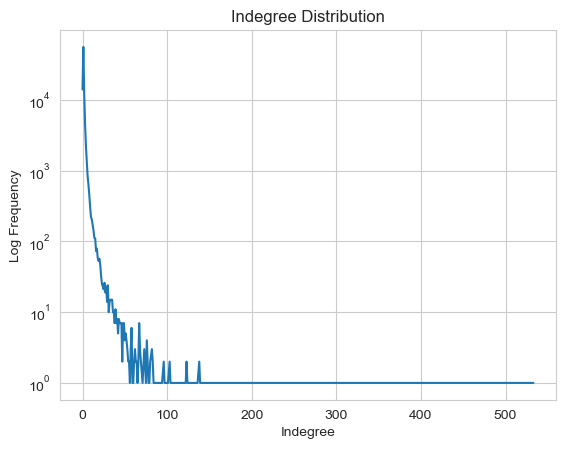

In [21]:
from collections import Counter, OrderedDict

in_degree = Counter(in_degree)
sorted_in_degree = OrderedDict(sorted(in_degree.items(), key=lambda x: x[0]))
indegree = list(sorted_in_degree.keys())
frequencies = list(sorted_in_degree.values())

plt.plot(indegree, frequencies)
plt.yscale('log') 
plt.title("Indegree Distribution")
plt.xlabel("Indegree")
plt.ylabel("Log Frequency")

Text(0, 0.5, 'Log Frequency')

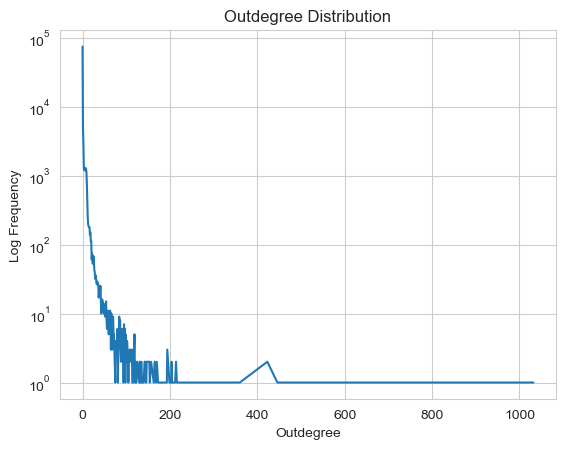

In [22]:
out_degree = list(dict(G.out_degree(weight = "weight")).values())
out_degree = Counter(out_degree)
sorted_out_degree = OrderedDict(sorted(out_degree.items(), key=lambda x: x[0]))
outdegree = list(sorted_out_degree.keys())
frequencies = list(sorted_out_degree.values())

plt.plot(outdegree, frequencies)
plt.yscale('log') 
plt.title("Outdegree Distribution")
plt.xlabel("Outdegree")
plt.ylabel("Log Frequency")

In [16]:
skew(out_degree)

28.332870259418744

In [17]:
kurtosis(out_degree)

1795.711302286719

In [6]:
nx.average_clustering(G, weight = "weight")

0.00023193023718975388

In [27]:
for u, v, data in largest_strongly_graph.edges(data=True):
    data['inverse_weight'] = 1.0 / data['weight']

distance = []
for source, dictionary in nx.all_pairs_shortest_path_length(largest_strongly_graph):
    distances = list(dictionary.values())
    distances.remove(0)
    distance.extend(distances)

In [28]:
np.mean(distance)

5.867868473283636

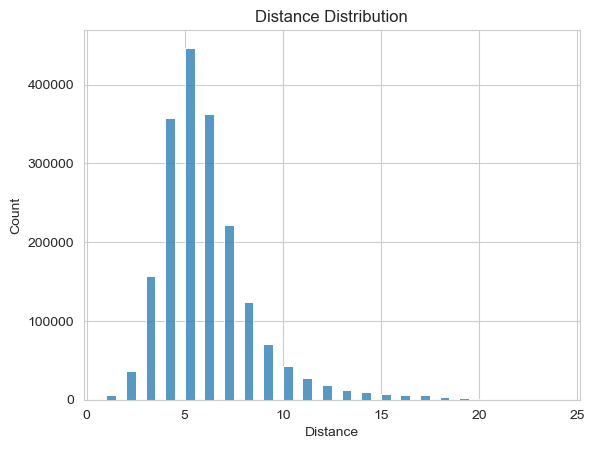

In [31]:
sns.histplot(distance, binwidth=0.5)
plt.title("Distance Distribution")
plt.xlabel("Distance")
plt.show()

In [3]:
# 3.3

In [3]:
for u, v, data in G.edges(data=True):
    data['inverse_weight'] = 1.0 / data['weight']

In [4]:
undirected_G = G.to_undirected()

In [5]:
betweenness_centrality = nx.betweenness_centrality(undirected_G, weight = "inverse_weight", k = 999)

In [8]:
betweenness_20 = dict(sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True)[:20])
betweenness_20

{'tamaraschilling': 0.22785346359553063,
 'starlingpoet': 0.13985681659685295,
 'TamaraSchilling': 0.0749170630072168,
 'MATT_369': 0.06448149793324554,
 'topfollowfriday': 0.0544739735490907,
 'centerpet': 0.04208520934636123,
 'Bonniestwit': 0.0402128221735005,
 'ModelSupplies': 0.03999636130700315,
 'teddy_salad': 0.03885082252184085,
 'mashable': 0.035104623563422276,
 'AmericanWomannn': 0.03424171004980557,
 'loveandemulsion': 0.03129250619804801,
 'medic_ray': 0.030771146347000008,
 'modelsupplies': 0.030233297707193806,
 'erenwall': 0.029376650883194837,
 'EMarketingGuru': 0.0287478050178086,
 'MamaCapps': 0.028289147729462106,
 'tmjobrequest': 0.027974813127400414,
 'andreapuddu': 0.025376999855299502,
 'tap29': 0.023748131999327522}

In [30]:
betweenness_20 = {'tamaraschilling': 0.22785346359553063,
 'starlingpoet': 0.13985681659685295,
 'TamaraSchilling': 0.0749170630072168,
 'MATT_369': 0.06448149793324554,
 'topfollowfriday': 0.0544739735490907,
 'centerpet': 0.04208520934636123,
 'Bonniestwit': 0.0402128221735005,
 'ModelSupplies': 0.03999636130700315,
 'teddy_salad': 0.03885082252184085,
 'mashable': 0.035104623563422276,
 'AmericanWomannn': 0.03424171004980557,
 'loveandemulsion': 0.03129250619804801,
 'medic_ray': 0.030771146347000008,
 'modelsupplies': 0.030233297707193806,
 'erenwall': 0.029376650883194837,
 'EMarketingGuru': 0.0287478050178086,
 'MamaCapps': 0.028289147729462106,
 'tmjobrequest': 0.027974813127400414,
 'andreapuddu': 0.025376999855299502,
 'tap29': 0.023748131999327522}

In [5]:
G_nk = nk.nxadapter.nx2nk(undirected_G, weightAttr = "weight")

In [20]:
idmap = dict((id, u) for (id, u) in zip(range(undirected_G.number_of_nodes()), undirected_G.nodes()))

In [24]:
ac = nk.centrality.ApproxCloseness(G_nk, 9999)
ac.run()

In [25]:
ids = [i[0] for i in ac.ranking()[:20]]

In [26]:
closeness_20 = [idmap.get(i) for i in ids]

In [27]:
closeness_20

['dropsy',
 'liltanlines',
 '100gran',
 '1041stormgirl',
 '10investigates',
 '10thamendment',
 'nikkipilkington',
 '140tc',
 'wyshynski',
 'tommysalami',
 'scotteweinberg',
 'markolivas',
 '15th',
 'motherlove_',
 '17thstreetbbq',
 '1970something',
 '1980_',
 'aliciawag',
 '1angelinwaiting',
 '1basil1']

In [29]:
degree_centrality = nx.degree_centrality(undirected_G)
degree_20 = dict(sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)[:20])
degree_20

{'tamaraschilling': 0.006486532021986817,
 'mashable': 0.005233451972284818,
 'medic_ray': 0.004127793104900701,
 'americandream09': 0.0040119621759366515,
 'elocio': 0.003864540993618769,
 'erenwall': 0.0038013604869111053,
 'bacieabbracci': 0.0034959880378240635,
 'drjennifer': 0.003474927868921509,
 'lauralassiter': 0.0032222058420908538,
 'centerpet': 0.0031590253353831897,
 'nachhi': 0.0031484952509319127,
 'teddy_salad': 0.0030116041530653076,
 'jhillstephens': 0.002801002464039762,
 'secularstupid': 0.002801002464039762,
 'straightstreet': 0.00276941221068593,
 'pcpitcrew': 0.002737821957332098,
 'bobgarrett': 0.0026219910283680477,
 'kellythomas1': 0.00261146094391677,
 'tweetmeme': 0.0023692690015373924,
 'carelea': 0.0023692690015373924}

In [37]:
from scipy.stats import spearmanr

corr_bet_degree = spearmanr(list(degree_20.values()), list(betweenness_20.values()))
corr_bet_degree

SignificanceResult(statistic=0.9992478374264834, pvalue=7.297503473551486e-27)

In [3]:
# 3.4

In [7]:
for i in range(20):
    resolution = i + 1
    score = nx.community.modularity(largest_strongly_graph, nx.community.greedy_modularity_communities(largest_strongly_graph, weight="weight", resolution=resolution))
    print(f"resolution = {resolution}, score = {score}")

resolution = 1, score = 0.48197034936809646
resolution = 2, score = 0.4689829256196955
resolution = 3, score = 0.4548775551275487
resolution = 4, score = 0.43960667901064265
resolution = 5, score = 0.43330880259699767
resolution = 6, score = 0.4243148871888733
resolution = 7, score = 0.42002596190851277
resolution = 8, score = 0.4118933932552045
resolution = 9, score = 0.4059033626262185
resolution = 10, score = 0.40229772235162375
resolution = 11, score = 0.39585879246493894
resolution = 12, score = 0.3907630357536352
resolution = 13, score = 0.38757531537787326
resolution = 14, score = 0.38460516934660166
resolution = 15, score = 0.3817154629829242
resolution = 16, score = 0.3742690778532392
resolution = 17, score = 0.37132715179183273
resolution = 18, score = 0.36887168977956425
resolution = 19, score = 0.3667168620395239
resolution = 20, score = 0.3633852824254354


In [8]:
communities = nx.community.greedy_modularity_communities(largest_strongly_graph, weight="weight", resolution=1, best_n = 10)

In [9]:
sizes = [len(i) for i in communities]
sizes

[229, 176, 167, 150, 133, 120, 115, 105, 99, 92]

In [10]:
for community in communities:
    graph = G.subgraph(community)
    hubs, authorities = nx.hits(graph)
    top_hubs = sorted(hubs, key=hubs.get, reverse=True)[:5]
    top_authorities = sorted(authorities, key=authorities.get, reverse=True)[:5]
    print("top_hubs: ",top_hubs)
    print("top_authorities: ",top_authorities)
    print("*"*100)

top_hubs:  ['lattegirltoo', 'andreapuddu', 'sugarjojo', 'letsdance_08', 'libertygrrrl']
top_authorities:  ['letsdance_08', 'jhillstephens', 'nursemom90', 'shannonseek', 'bloggerjoe']
****************************************************************************************************
top_hubs:  ['joetheproducer', 'modelsupplies', 'ncfcog', 'iggypintado', 'vicarsyf']
top_authorities:  ['ncfcog', 'vicarsyf', 'debrawruble', 'rmolden', 'iggypintado']
****************************************************************************************************
top_hubs:  ['emceet', 'raks1991', 'kinaton', 'audnumber', 'kcl2']
top_authorities:  ['kathykeefe', 'flowersophy', 'angellr', 'lizwertz', 'davorado']
****************************************************************************************************
top_hubs:  ['centerpet', 'grahamjoy', 'bacieabbracci', 'star_jayl', 'erenwall']
top_authorities:  ['melisangel', 'lauralassiter', 'wecomparebooks', 'bigblendmag', 'star_jayl']
***********************

In [25]:
nx.write_gml(largest_weakly_graph, "largest_weakly_graph.gml")

In [32]:
nx.write_gml(largest_strongly_graph, "largest_strongly_graph.gml")

In [2]:
# 3，6

In [3]:
weights = pd.read_csv("q31.csv", header=None, usecols=[2], names = ["weight"])

Text(0, 0.5, 'Log Frequency')

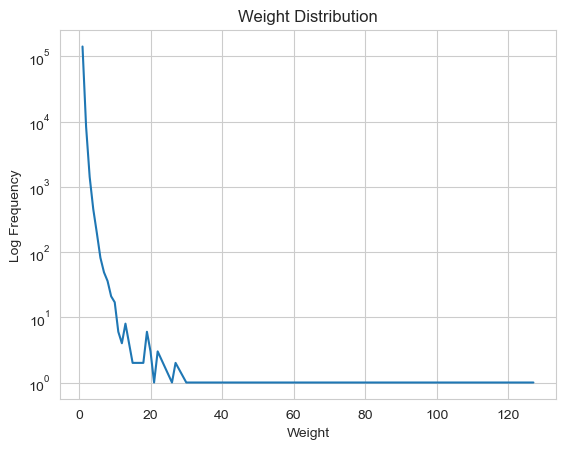

In [12]:
from collections import Counter, OrderedDict

weight = Counter(list(weights["weight"]))
sorted_weight = OrderedDict(sorted(weight.items(), key=lambda x: x[0]))
weight = list(sorted_weight.keys())
frequencies = list(sorted_weight.values())

plt.plot(weight, frequencies)
plt.yscale('log') 
plt.title("Weight Distribution")
plt.xlabel("Weight")
plt.ylabel("Log Frequency")

In [28]:
from scipy.stats import kurtosis, skew

skew(weights["weight"])

63.476695119451605

In [29]:
kurtosis(weights["weight"])

10210.742877303821